Copyright (c) European Space Agency, 2024.  
This file is subject to the terms and conditions defined in file 'LICENCE.txt',   
which is part of this source code package. No part of the package, including  
this file, may be copied, modified, propagated, or distributed except according to   
the terms contained in the file ‘LICENCE.txt’.

# Analysis of Gaia measurement timeseries that led to the discovery of the black hole `Gaia BH3`
## This notebook was prepared by the Gaia collaboration. If you find it useful for your research or otherwise, please reference the discovery paper (Gaia Collaboration, Panuzzo, et. al. 2024 "Discovery of a dormant 33 solar-mass black hole in pre-release Gaia astrometry") and the DOI associated with this notebook repository.

## Content of this notebook  
This notebook demonstrates the following steps:
- Load the timeseries data of the Gaia astrometric instrument. The data are identical to the ones published with the paper and available at the CDS.
- Fit an orbit to the astrometric data and determine the black hole's mass.
- Load the timeseries data of the Gaia radial-velocity instrument. The data are identical to the ones published with the paper and available at the CDS.
- Fit an orbit to the combination of astrometric and radial-velocity data and determine the black hole's mass.

## Environment installation
- This notebook is most easily executed within the associated `Binder` environment in a web browser, where no software installation is needed.
- For local execution, one can use the environment.yml file included in this repository to create a python environment using conda with the necessary dependencies for code execution:  
`conda env create --file gaia-bhthree/environment.yml`

### Imports

In [1]:
from collections import OrderedDict
import copy
import os

from astropy.time import Time
import astropy.units as u
from IPython.display import display, Markdown
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd

from kepmodel.astro import AstroModel as AstrometricModel
from kepmodel.rv import RvModel
from kepmodel.astrorv import AstroRvModel
from pystrometry.pystrometry import convert_from_angular_to_linear, pjGet_m2, OrbitSystem, MS_kg, MJ_kg, convert_from_linear_to_angular
from pystrometry import gaia_astrometry as gaia_astrometry_plotter
import spleaf

### Folder and constants definition

In [2]:
base_dir = os.getcwd()
data_dir = os.path.join(base_dir)
plot_dir = os.path.join(base_dir)

DR4_REFERENCE_EPOCH = Time('2017.5', format='jyear', scale='tcb')

### Source parameters from paper

In [3]:
source_id = 4318465066420528000
m1_MS = 0.76  # Primary star mass from paper Table 3
bh3_ra_deg = 294.8278502411 # Right Ascension from paper Table 2
bh3_dec_deg = 14.9309190720 # Declination from paper Table 2

## Load astrometric-timeseries data

In [4]:
columns = 'transit_id ccd_id obs_time_tcb centroid_pos_al centroid_pos_error_al parallax_factor_al scan_pos_angle outlier_flag'.split()
gaia_astrometry = pd.read_csv('epochast.dat', names=columns, delim_whitespace=True, comment='#')

# filter our unused data
gaia_astrometry = gaia_astrometry[gaia_astrometry['outlier_flag']!=1]

# set auxiliary fields
gaia_astrometry['source_id']  = source_id
gaia_astrometry['transitid'] = gaia_astrometry['transit_id']
gaia_astrometry['relative_time_year'] = Time(gaia_astrometry['obs_time_tcb'], format='jd', scale='tcb').jyear - DR4_REFERENCE_EPOCH.jyear
gaia_astrometry['mjd'] = Time(gaia_astrometry['obs_time_tcb'], format='jd', scale='tcb').mjd
gaia_astrometry['relative_time_day'] = gaia_astrometry['relative_time_year'] * u.year.to(u.day)
gaia_astrometry['cpsi_obs'] = np.cos(np.deg2rad(gaia_astrometry['scan_pos_angle']))
gaia_astrometry['spsi_obs'] = np.sin(np.deg2rad(gaia_astrometry['scan_pos_angle']))
gaia_astrometry['ppfact_obs'] = gaia_astrometry['parallax_factor_al']
gaia_astrometry['da_mas'] = gaia_astrometry['centroid_pos_al']
gaia_astrometry['sigma_da_mas'] = gaia_astrometry['centroid_pos_error_al']

### Display a few data records

In [5]:
columns_to_show = 'source_id transit_id ccd_id relative_time_year centroid_pos_al centroid_pos_error_al parallax_factor_al scan_pos_angle'.split()
display(gaia_astrometry.query('ccd_id == 1')[columns_to_show].sample(10, random_state=1).sort_values('relative_time_year'))

,source_id,transit_id,ccd_id,relative_time_year,centroid_pos_al,centroid_pos_error_al,parallax_factor_al,scan_pos_angle
17,4318465066420528000,22150086612000799,1,-2.578958,379.996,0.446,-0.466571,-5.114377
236,4318465066420528000,52687653750370648,1,-1.066927,-7.920,0.268,0.394007,107.029731
281,4318465066420528000,60072325242450363,1,-0.701310,93.716,0.207,-0.714470,35.396723
317,4318465066420528000,69681710950008689,1,-0.225529,0.132,0.141,0.701433,128.854659
325,4318465066420528000,69685803249345627,1,-0.225327,0.116,0.156,0.702254,128.754022
423,4318465066420528000,91999756014371726,1,0.879512,128.743,0.174,-0.602385,-169.403439
440,4318465066420528000,97549895534830543,1,1.154323,-170.556,0.189,0.232098,10.434803
502,4318465066420528000,100312802889225719,1,1.291104,-77.868,0.205,0.703518,-52.649855
569,4318465066420528000,112761770976220367,1,1.907498,278.254,0.153,-0.504061,178.451251
587,4318465066420528000,120150603084362450,1,2.273328,-311.529,0.213,-0.695162,40.015033


## Fit the standard astrometric model 
The standard astrometric model for the motion $w_\mathrm{ss}$ of a single star can be written as
\begin{equation}
w_\mathrm{ss} = ( \Delta\alpha^{\star} + \mu_{\alpha^\star} \, t ) \, \sin \psi + ( \Delta\delta + \mu_\delta \, t ) \, \cos \psi + \varpi \, f_\varpi, 
\end{equation}
where $\Delta\alpha^{\star} = \Delta\alpha \cos{\delta}$ and $\Delta \delta$ are small offsets in equatorial coordinates from a fixed reference point ($\alpha_0$, $\delta_0$), $\mu_{\alpha^\star}$ and $\mu_\delta$ are proper motions in these coordinates, $t$ is time since the Gaia DR4 reference time J2017.5, $\varpi$ is the parallax, $f_\varpi$ is the parallax factor, and $\psi$ is the instantaneous Gaia scan angle. For more details see Section 3 of https://www.aanda.org/articles/aa/full_html/2023/06/aa44161-22/aa44161-22.html and https://www.aanda.org/articles/aa/full_html/2023/06/aa43969-22/aa43969-22.html

We use the open-source python package [kepmodel](https://obswww.unige.ch/~delisle/kepmodel/doc/) (Delisle & Ségransan, 2022, A&A, 667, A172), which allows us to model radial velocity and/or astrometric time series including Keplerian orbits.

In [6]:
include_jitter_term = False

if include_jitter_term:
    astrometric_jitter_value = 0.05
else:
    astrometric_jitter_value = 0.0
    
# set up the single-star model with an additional jitter term of 0.05 mas
single_star_model = AstrometricModel(gaia_astrometry['relative_time_day'].values, 
                                     gaia_astrometry['centroid_pos_al'].values, 
                                     gaia_astrometry['cpsi_obs'].values, 
                                     gaia_astrometry['spsi_obs'].values, 
                                     err=spleaf.term.Error(gaia_astrometry['centroid_pos_error_al'].values),
                                     jit=spleaf.term.Jitter(astrometric_jitter_value))
    
# define the linear parameters
single_star_model.add_lin(gaia_astrometry['spsi_obs'].values, 'ra')
single_star_model.add_lin(gaia_astrometry['cpsi_obs'].values, 'dec')
single_star_model.add_lin(gaia_astrometry['parallax_factor_al'].values, 'parallax')
single_star_model.add_lin(gaia_astrometry['relative_time_year'].values * gaia_astrometry['spsi_obs'].values, 'mura')
single_star_model.add_lin(gaia_astrometry['relative_time_year'].values * gaia_astrometry['cpsi_obs'].values, 'mudec')

# add jitter term
if include_jitter_term:
    single_star_model.fit_param += ['cov.jit.sig']

# perform the fit
single_star_model.fit()

print("Best-fit single-star model parameters: (the units are mas and mas/year)")
single_star_model.show_param()

Best-fit single-star model parameters: (the units are mas and mas/year)
Parameter                        Value     Error       
lin.ra                         1.50624  ±  0.00708     
lin.dec                       -0.03341  ±  0.00674     
lin.parallax                   0.71520  ±  0.00871     
lin.mura                     -30.29679  ±  0.00477     
lin.mudec                   -148.62246  ±  0.00427     



## Fit the Keplerian astrometric model 

Using [kepmodel](https://obswww.unige.ch/~delisle/kepmodel/doc/), we first compute the periodogram of the residuals of the standard-model fit. With the estimated period we initialise a Keplerian model and fit it to the data.

The astrometric motion corresponding to a Keplerian orbit of a binary system has generally seven independent parameters. These
are the period $P$, the epoch of periastron passage $T_0$, the eccentricity $e$, the inclination $i$, the ascending node $\Omega$, the argument of periastron $\omega$, and the semi-major axis of the photocentre $a_0$. The Thiele-Innes coefficients $A, B, F, G$, which linearise part of the equations, are defined as
\begin{eqnarray}
%\begin{split}
% \begin{array}{ll}
A &=&  \ \ \, a_0 \; (\cos \omega \cos \Omega - \sin \omega \sin \Omega \cos i)   \\
B &=&  \ \ \, a_0 \; (\cos \omega \sin \Omega + \sin \omega \cos \Omega \cos i)  \\
F &=& -a_0 \; (\sin \omega \cos \Omega + \cos \omega \sin \Omega \cos i)  \\
G &=&  -a_0 \; (\sin \omega \sin \Omega - \cos \omega \cos \Omega \cos i) 
% \end{array}
%\end{split}
\end{eqnarray}

The elliptical rectangular coordinates $X$ and $Y$ are functions of eccentric anomaly $E$ and eccentricity: 
\begin{eqnarray}
E - e \sin E &=& \frac{2\pi}{P} (t-T_0)\\
X &=& \cos E - e\\
Y &=& \sqrt{1-e^2} \sin E
\end{eqnarray}

The single Keplerian model $w_\mathrm{k1}$ can then be written as 
\begin{equation}
w_\mathrm{k1} = (B \, X + G \, Y) \sin \psi + (A \, X + F \, Y) \cos \psi.
\end{equation}

The combined model $w^\mathrm{(model)}$ for the Gaia along-scan abscissa is
\begin{equation}
\begin{split}
w^\mathrm{(model)} =&\, w_\mathrm{ss} + w_\mathrm{k1} \\
 =&\, ( \Delta\alpha^{\star} + \mu_{\alpha^\star} \, t ) \, \sin \psi + ( \Delta\delta + \mu_\delta \, t ) \, \cos \psi + \varpi \, f_\varpi \\
 &+\, (B \, X + G \, Y) \sin \psi + (A \, X + F \, Y) \cos \psi.
\end{split}\end{equation}


More details are given in Section 3 of https://www.aanda.org/articles/aa/full_html/2023/06/aa44161-22/aa44161-22.html and in https://www.aanda.org/articles/aa/full_html/2023/06/aa43969-22/aa43969-22.html

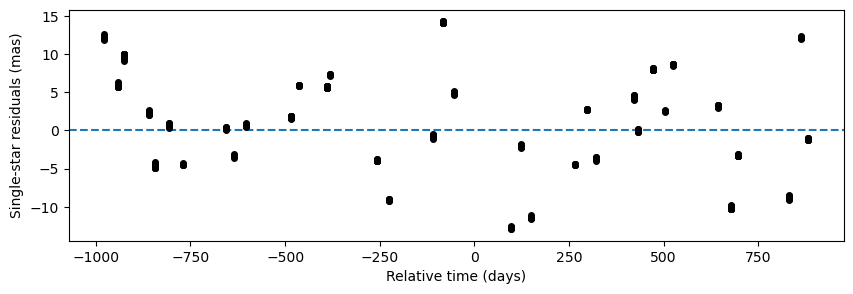

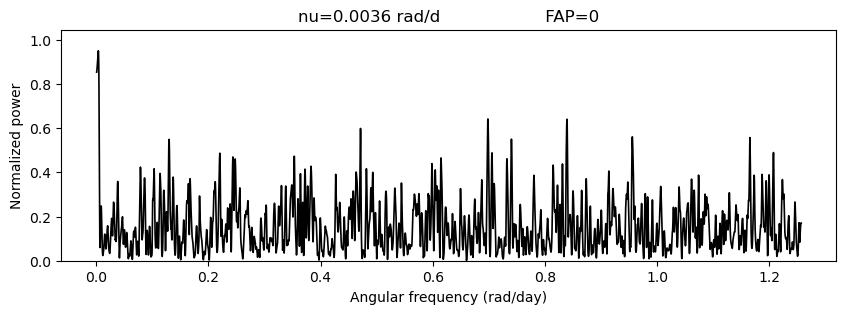

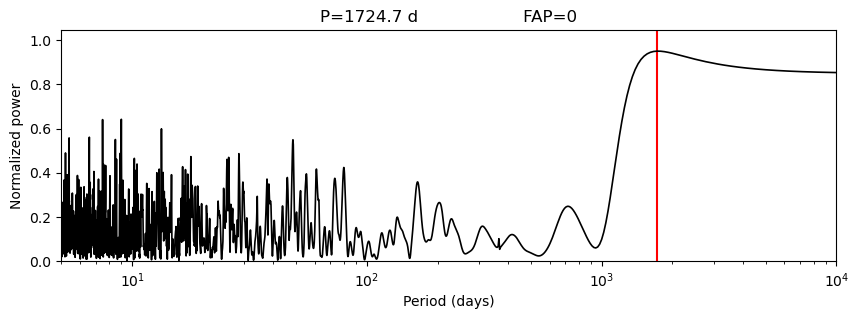

In [7]:
model = copy.deepcopy(single_star_model)

# Periodogram settings 
Pmin = 5
Pmax = 10000
nfreq = 10000
nu0 = 2 * np.pi / Pmax
dnu = (2 * np.pi / Pmin - nu0) / (nfreq - 1)

# plot the single-star residuals
resisuals = model.residuals()
res_err = np.sqrt(model.cov.A)
pl.figure(figsize=(10, 3))
pl.errorbar(model.t, resisuals, yerr=res_err, fmt='o', ecolor='0.7', ms=4, color='k')
pl.xlabel(f'Relative time (days)')
pl.ylabel('Single-star residuals (mas)')
pl.axhline(ls='--')
pl.show()    

# compute periodogram
nu, power = model.periodogram(nu0, dnu, nfreq)

# convert from angular frequency to period
P = 2 * np.pi / nu

# identify highest peak and compute false-alarm probability (FAP)
kmax = np.argmax(power)
faplvl = model.fap(power[kmax], nu.max())

# plot periodogram as a function of frequency
pl.figure(figsize=(10, 3))
pl.plot(nu, power, 'k', lw=1.2)
pl.ylim(0, 1.1 * power.max())
pl.xlabel('Angular frequency (rad/day)')
pl.ylabel('Normalized power')
pl.title(f'nu={nu[kmax]:.4f} rad/d' + 20*' ' + f'FAP={faplvl:.2g}')
pl.show()

# plot periodogram as a function of period
pl.figure(figsize=(10, 3))
pl.plot(2 * [P[kmax]], [0, 1.1 * power.max()], 'r')
pl.plot(P, power, 'k', lw=1.2, rasterized=True)
pl.xlim(Pmin, Pmax)
pl.ylim(0, 1.1 * power.max())
pl.xscale('log')
pl.xlabel('Period (days)')
pl.ylabel('Normalized power')
pl.title(f'P={P[kmax]:.1f} d' + 20*' ' + f'FAP={faplvl:.2g}')
pl.show()

## Fit the Keplerian model

In [8]:
keplerian_model = copy.deepcopy(model)

print(f'Adding a Keplerian with period {P[kmax]:.1f} days to model.\n')

keplerian_model.add_keplerian_from_period(P[kmax])

# fit the new model
keplerian_model.fit()

print(f"Best-fit parameter (Thiele-Innes coefficients)")
keplerian_model.show_param()

# print('Change orbital parameter set:')
param = ['P', 'Tp', 'as', 'e', 'w', 'i', 'bigw']
keplerian_model.set_keplerian_param(f'0', param=param)

print(f"Best-fit parameter (Campbell elements)\nkep.0.P is the period in days, kep.0.as is the semimajor axis in milli-arcseconds\n")
keplerian_model.show_param()    

Adding a Keplerian with period 1724.7 days to model.

Best-fit parameter (Thiele-Innes coefficients)
Parameter                        Value     Error       
lin.ra                          4.2639  ±  0.0578      
lin.dec                         2.4251  ±  0.0822      
lin.parallax                   1.68081  ±  0.00894     
lin.mura                      -28.3285  ±  0.0737      
lin.mudec                     -155.201  ±  0.124       
kep.0.P                           4236  ±  109         
kep.0.M0 [deg]                 339.554  ±  0.547       
kep.0.e                        0.72824  ±  0.00527     
kep.0.TIA                       2.3471  ±  0.0540      
kep.0.TIB                       10.752  ±  0.198       
kep.0.TIF                       20.669  ±  0.442       
kep.0.TIG                      -17.011  ±  0.311       

Best-fit parameter (Campbell elements)
kep.0.P is the period in days, kep.0.as is the semimajor axis in milli-arcseconds

Parameter                        Value     Error

## Compute the mass of the black hole

In [9]:
keplerian_parameters = {}
for i, key in enumerate(keplerian_model.keplerian['0']._param):
    keplerian_parameters[key] = keplerian_model.keplerian['0']._par[i]

linear_parameters = {}
for i, key in enumerate(keplerian_model._lin_name):
    linear_parameters[key] = keplerian_model._lin_par[i]

a_m = convert_from_angular_to_linear(keplerian_parameters['as'], linear_parameters['parallax'])
m2_kg = pjGet_m2(m1_MS * MS_kg, a_m, keplerian_parameters['P'])
m2_MS = m2_kg / MS_kg
mass_function = keplerian_parameters['as']**3 * (u.year.to(u.day))**2 / (keplerian_parameters['P']**2 * linear_parameters['parallax']**3)

display(Markdown(f'## <strong>Results from astrometry only:</strong>'))
display(Markdown(f'## <strong>The mass function value is {mass_function:.2f} solar masses</strong>'))
display(Markdown(f'## <strong>With a primary mass of {m1_MS} solar masses, the companion has a mass of {m2_MS:.2f} solar masses</strong><br/>'))

## <strong>Results from astrometry only:</strong>

## <strong>The mass function value is 31.87 solar masses</strong>

## <strong>With a primary mass of 0.76 solar masses, the companion has a mass of 33.34 solar masses</strong><br/>

## Create orbit model and display it together with the Gaia measurements

We use plotting tools provided by the open-source python package [pystrometry](https://github.com/Johannes-Sahlmann/pystrometry) (https://zenodo.org/records/10839734), which supports the analysis of high-precision astrometry timeseries. 

## <strong>The five figure panels below show the following (for a detailed description see https://www.aanda.org/articles/aa/full_html/2023/06/aa44161-22/F12.html):
Top left: Parallax and proper motion of the source projected on the sky  
Bottom left: On-sky orbital signature relative to the system's barycentre   
Top right: Orbital signature relative to the system barycentre as a function of time  
Middle right: Aggregated residuals as a function of time  
Bottom right: Individual residuals as a function of time </strong>

++++++++++++++++++++++++++++++
System parameters:
Distance is 595.0 pc 	 Parallax = 1.7 mas
Primary   mass = 0.760 Msol 	 = 796.150 Mjup
Secondary mass = 33.343 Msol 	 = 34928.781 Mjup 	 = 11101358.877 MEarth
Mass ratio q=m2/m1 = 43.872123
a1_mas    = 27.304, a_rel_mas = 27.926, a_rel_au = 16.615
Inclination  110.6 deg
Period is   4235.8 day 	 Eccentricity = 0.728
omega = 77.9 deg, OMEGA = 136.2 deg, T_periastron = 53941.1 day
RV semi-amplitude of primary = 56989.169 m/s



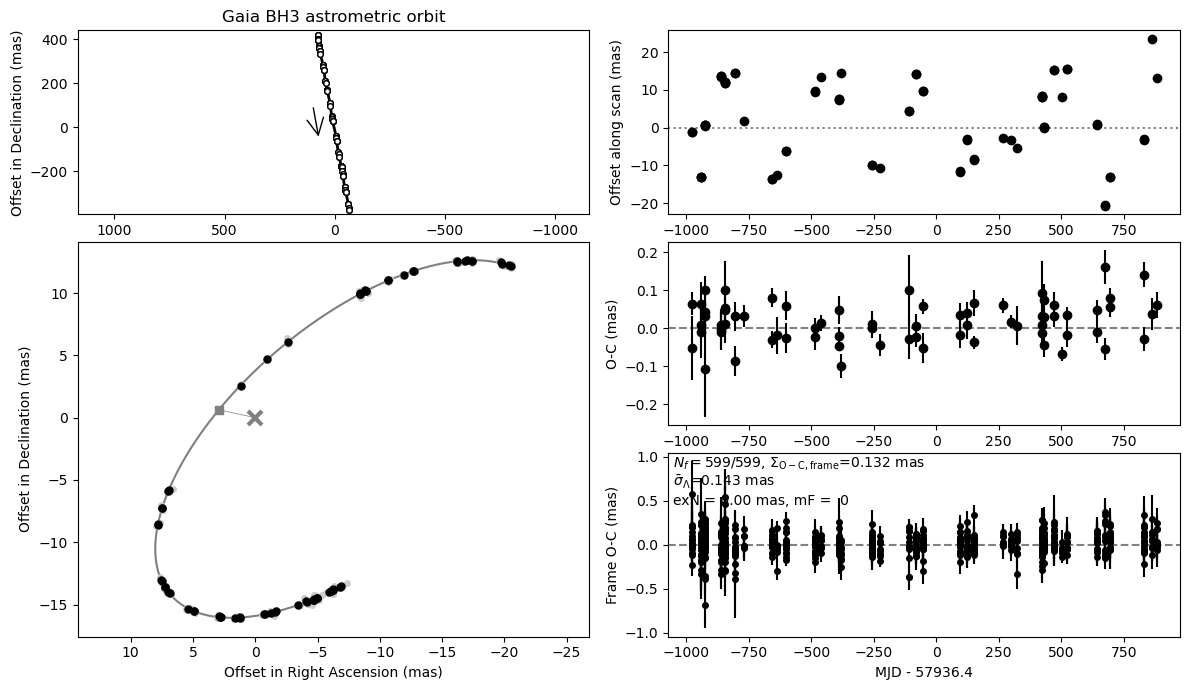

In [10]:
# A helper function for plotting
def plot_astrometry(astrometry_timeseries, parameter_df, plot_dir, reference_time, model_name):
    """Make a figure showing the model and the data."""
    
    source_id = parameter_df.loc[0, 'source_id']

    iad = gaia_astrometry_plotter.GaiaValIad.from_dataframe(astrometry_timeseries, source_id, 'source_id')

    iad._mjd_field = 'mjd'
    iad.time_column = 'relative_time_year'
    iad.set_reference_time(reference_time)

    parameter_dict = parameter_df[parameter_df['source_id'] == source_id].iloc[0].to_dict()
    parameter_dict['source_id'] = np.int64(source_id)
    parameter_dict['name_seed'] = f"{source_id}_{model_name}"
    if model_name == 'multiple_star':
        axp = gaia_astrometry_plotter.plot_individual_orbit(parameter_dict, iad, plot_dir=plot_dir, m1_MS=parameter_dict['m1_MS'])
    return axp
    
reference_time = DR4_REFERENCE_EPOCH
model_name = 'multiple_star'

attribute_dict = OrderedDict([  
                                ('ra', bh3_ra_deg), 
                                ('dec', bh3_dec_deg),    
                                ('absolute_plx_mas', linear_parameters['parallax']), 
                                ('muRA_mas', linear_parameters['mura']),
                                ('muDE_mas', linear_parameters['mudec']),
                                ('muAlphaStar_masPyr', linear_parameters['mura']),
                                ('muDelta_masPyr', linear_parameters['mudec']),
                                ('Tref_MJD', reference_time.mjd),
                                ('scan_angle_definition', 'gaia'),
                             ])  

attribute_dict['m2_MJ'] = m2_kg / MJ_kg
attribute_dict['m1_MS'] = m1_MS
attribute_dict['P_day'] = keplerian_parameters['P']
attribute_dict['p1_omega_deg'] = np.rad2deg(keplerian_parameters['w'])
attribute_dict['ecc'] = keplerian_parameters['e']
attribute_dict['p1_OMEGA_deg'] = np.rad2deg(keplerian_parameters['bigw'])
attribute_dict['p1_incl_deg'] = np.rad2deg(keplerian_parameters['i'])
attribute_dict['p1_Tp_day'] = attribute_dict['Tref_MJD'] + keplerian_parameters['Tp']  # this is in MJD
attribute_dict['p1_a1_mas'] = keplerian_parameters['as']
attribute_dict['p1_ecc'] = keplerian_parameters['e']
attribute_dict['p1_period_day'] = keplerian_parameters['P']
attribute_dict['p1_Tp_day-T0'] = keplerian_parameters['Tp']
attribute_dict['offset_alphastar_mas'] = linear_parameters['ra']
attribute_dict['offset_delta_mas'] = linear_parameters['dec']

attribute_dict['source_id'] = source_id

attribute_dict['epoch_omc_description'] = ''
attribute_dict['orbit_signal_description'] = ''
attribute_dict['orbit_description'] = [['']]
attribute_dict['ppm_description'] = ''
attribute_dict['title'] = 'Gaia BH3 astrometric orbit'
attribute_dict['frame_omc_description'] = ''


display(Markdown(f'## <strong>The five figure panels below show the following (for a detailed description see https://www.aanda.org/articles/aa/full_html/2023/06/aa44161-22/F12.html):\nTop left: Parallax and proper motion of the source projected on the sky  \nBottom left: On-sky orbital signature relative to the system\'s barycentre   \nTop right: Orbital signature relative to the system barycentre as a function of time  \nMiddle right: Aggregated residuals as a function of time  \nBottom right: Individual residuals as a function of time </strong>'))
axp = plot_astrometry(gaia_astrometry, pd.DataFrame(attribute_dict, index=[0]), plot_dir, reference_time, model_name)    

# Combined analysis of astrometric and radial-velocity timeseries

## Load radial-velocity timeseries data

In [11]:
columns = 'transit_id obs_time_tcb radial_velocity radial_velocity_err'.split()
gaia_rv = pd.read_csv('epochrv.dat', names=columns, delim_whitespace=True, comment='#')
gaia_rv['relative_time_year'] = Time(gaia_rv['obs_time_tcb'], format='jd', scale='tcb').jyear - DR4_REFERENCE_EPOCH.jyear
gaia_rv['relative_time_day'] = gaia_rv['relative_time_year'] * u.year.to(u.day)

## Set up a the combined astrometry + radial-velocity model and fit it to the data

In [12]:
# fit the simplest radial-velocity model (constant offset)
rv_default_jitter = 0.0
rv_model = RvModel(
  gaia_rv['relative_time_day'].values,
  gaia_rv['radial_velocity'].values*1e3,
  err=spleaf.term.Error(gaia_rv['radial_velocity_err'].values*1e3),
  jit=spleaf.term.Jitter(rv_default_jitter*1e3),
)
rv_model.add_lin(np.ones(len(gaia_rv)), 'rv_offset')
rv_model.fit()
# rv_model.show_param()

# set up a fresh single-star model 
single_star_model = AstrometricModel(gaia_astrometry['relative_time_day'].values, 
                                     gaia_astrometry['centroid_pos_al'].values, 
                                     gaia_astrometry['cpsi_obs'].values, 
                                     gaia_astrometry['spsi_obs'].values, 
                                     err=spleaf.term.Error(gaia_astrometry['centroid_pos_error_al'].values),
                                     jit=spleaf.term.Jitter(astrometric_jitter_value),
                                     angular_keplerian_param=False)

# define the linear parameters
single_star_model.add_lin(gaia_astrometry['spsi_obs'].values, 'ra')
single_star_model.add_lin(gaia_astrometry['cpsi_obs'].values, 'dec')
single_star_model.add_lin(gaia_astrometry['parallax_factor_al'].values, 'plx')
single_star_model.add_lin(gaia_astrometry['relative_time_year'].values * gaia_astrometry['spsi_obs'].values, 'mura')
single_star_model.add_lin(gaia_astrometry['relative_time_year'].values * gaia_astrometry['cpsi_obs'].values, 'mudec')

# add jitter term
if include_jitter_term:
    single_star_model.fit_param += ['cov.jit.sig']

# perform the single-star fit
single_star_model.fit()

# set up and fit the combined model (astrometry + radial velocity)
full_model = AstroRvModel(single_star_model, rv_model)
full_model.add_keplerian_from_period(P[kmax])
full_model.fit()
full_model.show_param()

Parameter                        Value     Error       
astro.lin.ra                    4.2795  ±  0.0500      
astro.lin.dec                   2.4016  ±  0.0649      
astro.lin.plx                  1.68356  ±  0.00774     
astro.lin.mura                -28.3491  ±  0.0573      
astro.lin.mudec              -155.1707  ±  0.0978      
rv.lin.rv_offset               -357210  ±  402         
kep.0.P                         4210.2  ±  86.0        
kep.0.assini                    15.105  ±  0.238       
kep.0.M0 [deg]                 339.437  ±  0.449       
kep.0.e                        0.72699  ±  0.00426     
kep.0.omega [deg]               77.816  ±  0.152       
kep.0.i [deg]                 110.6141  ±  0.0892      
kep.0.bigomega [deg]           136.190  ±  0.121       



## Recompute the mass of the black hole

In [13]:
keplerian_parameters = {}
for i, key in enumerate(full_model.keplerian['0']._param):
    keplerian_parameters[key] = full_model.keplerian['0']._par[full_model.keplerian['0']._index[i]]

linear_parameters = {}
for i, key in enumerate(single_star_model._lin_name):
    linear_parameters[key] = single_star_model._lin_par[i]

rv_parameters = {}
for i, key in enumerate(rv_model._lin_name):
    rv_parameters[key] = rv_model._lin_par[i]

keplerian_parameters['as_au'] = keplerian_parameters['assini']/np.sin(keplerian_parameters['i'])
keplerian_parameters['as_m'] = keplerian_parameters['as_au'] * u.astronomical_unit.to(u.m)
keplerian_parameters['as_mas'] = convert_from_linear_to_angular(keplerian_parameters['as_m'], linear_parameters['plx'])
m2_kg = pjGet_m2(m1_MS * MS_kg, keplerian_parameters['as_m'], keplerian_parameters['P'])
m2_MS = m2_kg / MS_kg
mass_function = keplerian_parameters['as_mas']**3 * (u.year.to(u.day))**2 / (keplerian_parameters['P']**2 * linear_parameters['plx']**3)
display(Markdown(f'## <strong>Results from combined astrometry + radial-velocity analysis: </strong>'))
display(Markdown(f'## <strong>The mass function value is {mass_function:.2f} solar masses</strong>'))
display(Markdown(f'## <strong>With a primary mass of {m1_MS} solar masses, the companion has a mass of {m2_MS:.2f} solar masses</strong><br/>'))

# assume uncorrelated Gaussian errors and compute companion mass uncertainty
value, std = full_model.get_param_error(full_model.fit_param, 1e-6)
np.random.seed(1)
resampled = np.random.multivariate_normal(value, np.diag(np.nan_to_num(std)**2), size=10000)

def compute_companion_mass(assini_au, i_rad, plx_mas, period_day, m1_MS):
    as_au = assini_au/np.sin(i_rad)
    as_m = as_au * u.astronomical_unit.to(u.m)
    as_mas = convert_from_linear_to_angular(as_m, plx_mas)
    m2_kg = pjGet_m2(m1_MS * MS_kg, as_m, period_day)
    m2_MS = m2_kg / MS_kg

    mass_function_msun = as_mas**3 * (u.year.to(u.day))**2 / (period_day**2 * plx_mas**3)
    return m2_MS, mass_function_msun 

m2_MS_mc, mass_function_msun_mc = compute_companion_mass(resampled[:, full_model.fit_param.index('kep.0.assini')], 
                       resampled[:, full_model.fit_param.index('kep.0.i')], 
                       resampled[:, full_model.fit_param.index('astro.lin.plx')], 
                       resampled[:, full_model.fit_param.index('kep.0.P')], m1_MS)

display(Markdown(f'## <strong>Assuming uncorrelated Gaussian errors we obtain the uncertainties. These are larger than in the discovery paper, because here we do not account for the strong correlation between semimajor axis and period (see Section 2.2. of the paper): </strong>'))
display(Markdown(f'## <strong>Mass function =  {np.mean(mass_function_msun_mc):.1f} +/- {np.std(mass_function_msun_mc):.1f} solar masses</strong>'))
display(Markdown(f'## <strong>Black hole mass = {np.mean(m2_MS_mc):.1f} +/- {np.std(m2_MS_mc):.1f} solar masses</strong><br/>'))

## <strong>Results from combined astrometry + radial-velocity analysis: </strong>

## <strong>The mass function value is 31.63 solar masses</strong>

## <strong>With a primary mass of 0.76 solar masses, the companion has a mass of 33.10 solar masses</strong><br/>

## <strong>Assuming uncorrelated Gaussian errors we obtain the uncertainties. These are larger than in the discovery paper, because here we do not account for the strong correlation between semimajor axis and period (see Section 2.2. of the paper): </strong>

## <strong>Mass function =  31.7 +/- 2.0 solar masses</strong>

## <strong>Black hole mass = 33.2 +/- 2.0 solar masses</strong><br/>

## Plot radial velocity curve, the Gaia measurements, and the residuals

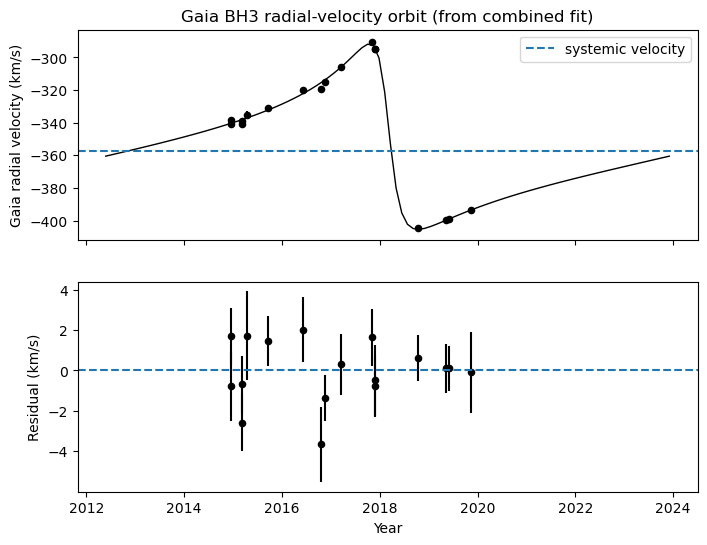

In [30]:
# create dictionary that defines the OrbitSystem
attribute_dict = {
    'gamma_ms': rv_parameters['rv_offset'],
    'P_day': keplerian_parameters['P'],
    'ecc': keplerian_parameters['e'],
    'omega_deg': np.rad2deg(keplerian_parameters['omega']),
    'OMEGA_deg': np.rad2deg(keplerian_parameters['bigomega']),
    'i_deg': np.rad2deg(keplerian_parameters['i']),
    'a_mas': keplerian_parameters['as_mas'],
    'Tp_day': DR4_REFERENCE_EPOCH.mjd + keplerian_parameters['P'] * (1-keplerian_parameters['M0']/(2*np.pi)), # Eq (1) in Sahlmann
    'm1_MS': m1_MS,
    'm2_MJ': m2_kg / MJ_kg,
    'Tref_MJD': DR4_REFERENCE_EPOCH.mjd,
}


n_figure_rows = 2; n_figure_columns=1;
fig, axes = pl.subplots(n_figure_rows, n_figure_columns, figsize=(n_figure_columns*8, n_figure_rows*3), facecolor='w', edgecolor='k', sharex=True,  sharey=False, squeeze=True)

# orbit panel
ax = axes[0]
pl.sca(ax)
orbit = OrbitSystem(attribute_dict=attribute_dict)
orbit.plot_rv_orbit()
gaia_rv['time_jyear'] = Time(gaia_rv['obs_time_tcb'], format='jd', scale='tcb').jyear
gaia_rv.plot('time_jyear', 'radial_velocity', yerr='radial_velocity_err', kind='scatter', ax=ax, color='k')
ax.axhline(rv_parameters['rv_offset']/1e3, ls='--', label='systemic velocity')
ax.legend()
ax.set_ylabel('Gaia radial velocity (km/s)')
ax.set_title('Gaia BH3 radial-velocity orbit (from combined fit)')

# residual panel
ax = axes[1]
gaia_rv['radial_velocity_model'] = orbit.compute_radial_velocity(gaia_rv['relative_time_day']+DR4_REFERENCE_EPOCH.mjd)/1e3
gaia_rv['radial_velocity_residual'] = gaia_rv['radial_velocity'] - gaia_rv['radial_velocity_model']
gaia_rv.plot('time_jyear', 'radial_velocity_residual', yerr='radial_velocity_err', ax=ax, kind='scatter', color='k')
ax.axhline(0, ls='--')
ax.set_xlabel('Year')
ax.set_ylabel('Residual (km/s)')
pl.show()

# Additional analyses 
* May 13 2024, Berry Holl 

## Plot model for coming years

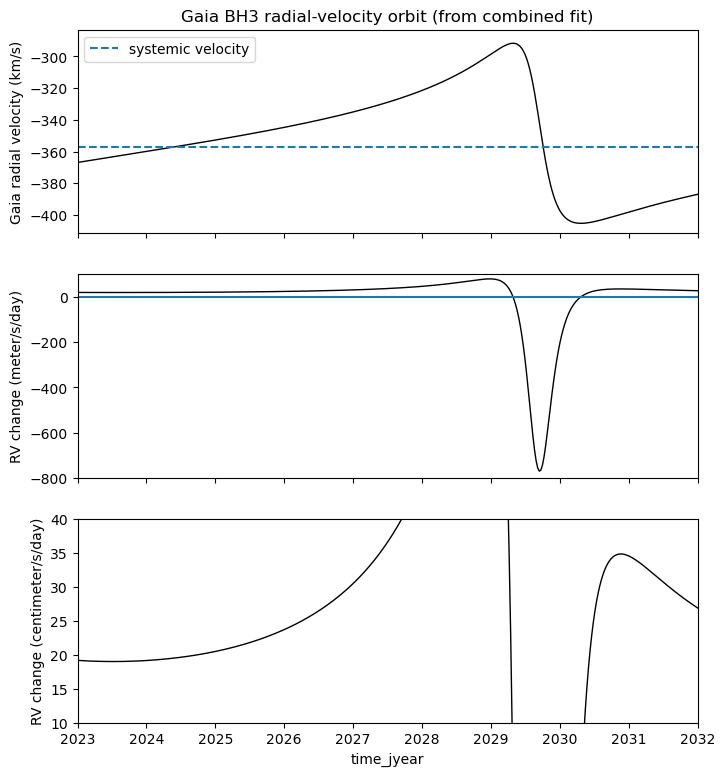

In [82]:
n_figure_rows = 3; n_figure_columns=1;
fig, axes = pl.subplots(n_figure_rows, n_figure_columns, figsize=(n_figure_columns*8, n_figure_rows*3), facecolor='w', edgecolor='k', sharex=True,  sharey=False, squeeze=True)

# orbit panel
ax = axes[0]
pl.sca(ax)
orbit = OrbitSystem(attribute_dict=attribute_dict)
orbit.plot_rv_orbit(n_curve=1000, n_orbit=2)
gaia_rv['time_jyear'] = Time(gaia_rv['obs_time_tcb'], format='jd', scale='tcb').jyear
gaia_rv.plot('time_jyear', 'radial_velocity', yerr='radial_velocity_err', kind='scatter', ax=ax, color='k')
ax.axhline(rv_parameters['rv_offset']/1e3, ls='--', label='systemic velocity')
ax.legend()
ax.set_ylabel('Gaia radial velocity (km/s)')
ax.set_title('Gaia BH3 radial-velocity orbit (from combined fit)')
#ax = plt.gca()
ax.set_xlim([2023, 2032])

# Try to reproduce orbit.plot_rv_orbit(n_curve=1000, n_orbit=2) from above 
line_color='k'
line_style='-'
line_width=1
rv_unit='kmps'
time_offset_day=0.
component ='primary'

t_day = np.linspace(0, keplerian_parameters['P'] * 2, 1000) - keplerian_parameters['P']/2 + attribute_dict['Tp_day'] + time_offset_day
t_plot = Time(t_day, format='mjd').jyear
rv_mps = (orbit.compute_radial_velocity(t_day, component=component)) 

# Compute derivative per day i.e. RV change per day
rv_mps_pd = np.gradient(rv_mps, t_day)

# second row plot
ax = axes[1]
ax.plot(t_plot, rv_mps_pd, ls=line_style, color=line_color, lw=line_width)
ax.set_ylim([-800, 100])
ax.set_ylabel('RV change (meter/s/day)')
ax.axhline(0, ls='-')

# second row plot
ax = axes[2]
ax.plot(t_plot, rv_mps_pd, ls=line_style, color=line_color, lw=line_width)
#ax.set_ylim([0.01, 0.04])
ax.set_ylim([10, 40])
gaia_rv.plot('time_jyear', 'radial_velocity', yerr='radial_velocity_err', kind='scatter', ax=ax, color='k')
ax.set_ylabel('RV change (meter/s/day)')


pl.show()

## Plot the astrometric orbit